In [1]:
%pip install -qU gigachain==0.2.6 gigachain_community==0.2.6 gigachain-cli==0.0.25 langgraph==0.2.19 langchain-community==0.2.16 langchain-openai==0.1.23  python-pptx==0.6.23 python-pptx-interface==0.0.12 python-dotenv==1.0.1 duckduckgo-search==6.2.4 faiss-cpu

Note: you may need to restart the kernel to use updated packages.


# 03 Seminar: LLM Agents

#### The differences between a single LLM and an LLM-Agent

**Single LLM**

* Function: Processes input and generates output based on its training.
* Interaction: Typically one-shot or simple back-and-forth exchanges.
* Capabilities: Limited to generating text based on prompts.
* External tools: Generally cannot use external tools or access real-time information.
* Decision-making: Doesn't make autonomous decisions or take actions.
* Context: Limited to information within its training data cutoff.

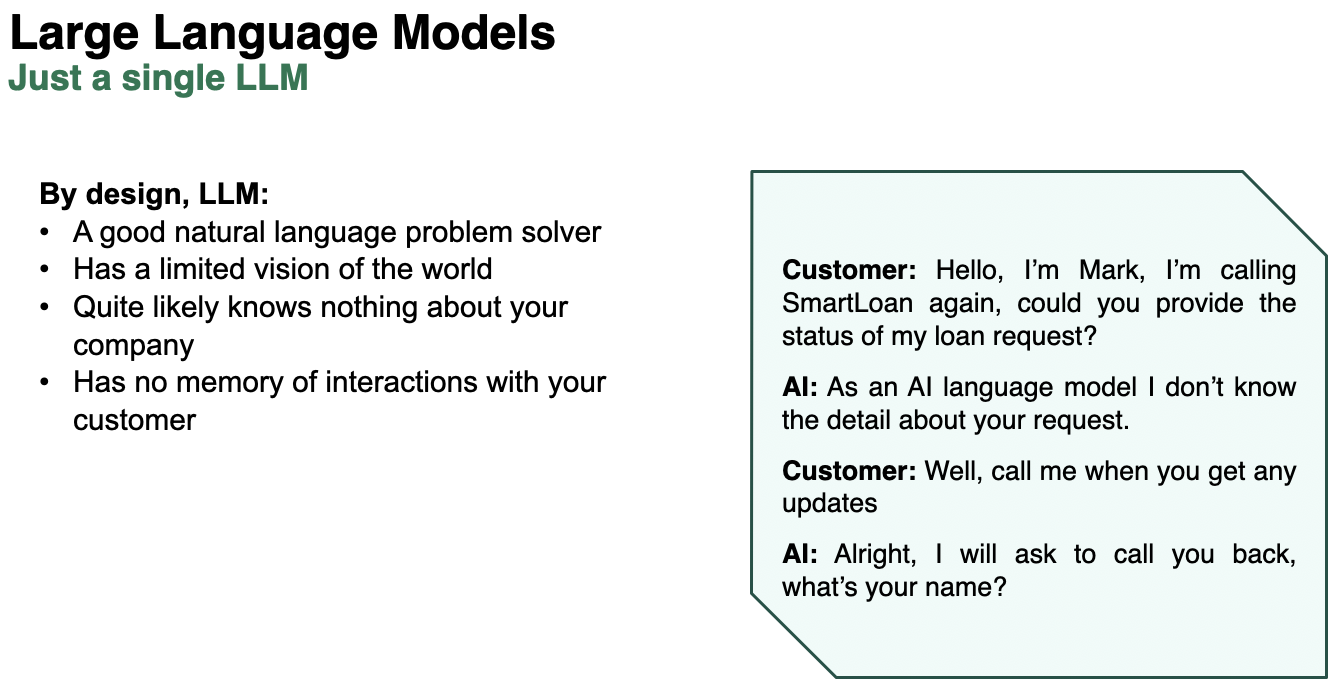

**LLM-Agent**

* Function: Uses an LLM as its core, but with additional layers of functionality.
* Interaction: Can engage in more complex, multi-step interactions.
* Capabilities: Can perform tasks, make decisions, and take actions.
* External tools: Can use various tools (e.g., web search, calculators, APIs) to augment its knowledge.
* Decision-making: Can make autonomous decisions based on goals and available information.
* Context: Can access and incorporate real-time or external information.
* Memory: Often equipped with short-term and sometimes long-term memory capabilities.
* Planning: Can break down complex tasks into steps and execute them sequentially.

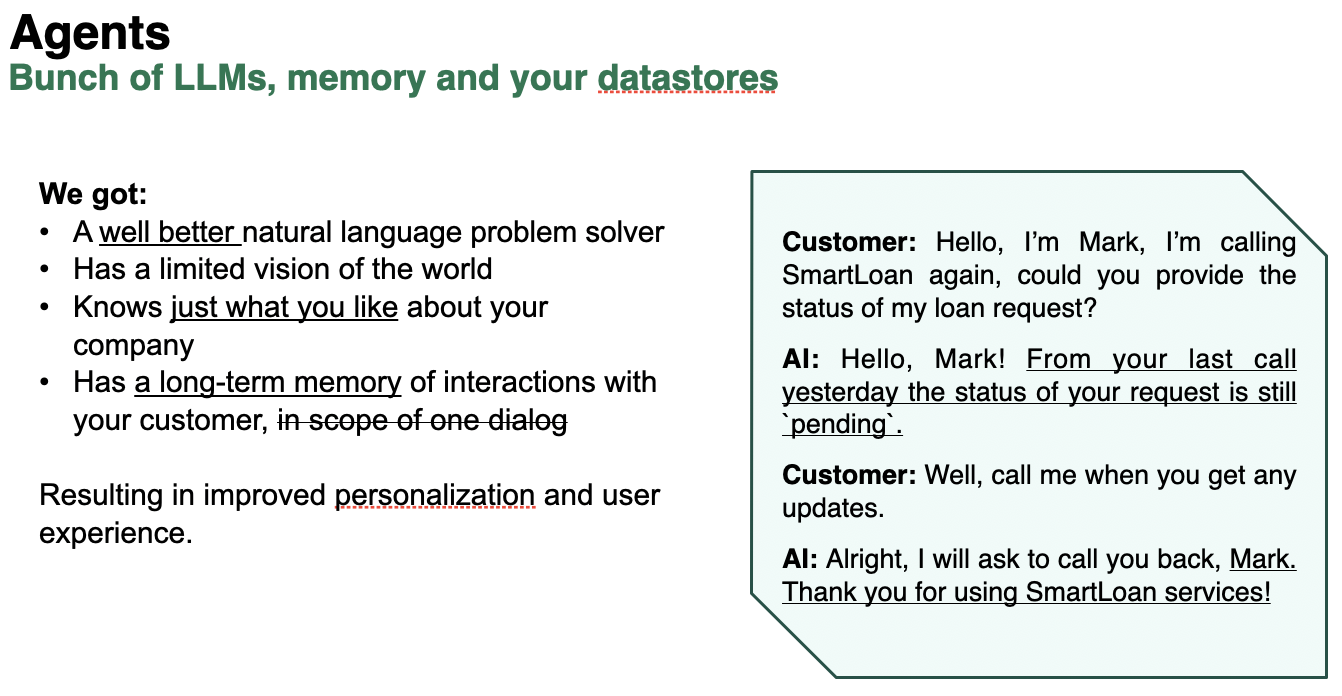

In [ ]:
import getpass
import os
import requests
import json
import time

In [ ]:
from dotenv import load_dotenv
# Load environment variables
load_dotenv('.env')

True

In [ ]:
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = os.getenv(var)

In [ ]:
_set_if_undefined("SB_AUTH_DATA")
_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TMDB_API_KEY")

In [ ]:
# Another way to define your creds

# def _set_if_undefined_another_way(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"Please provide your {var}")

# _set_if_undefined_another_way("SB_AUTH_DATA")
# _set_if_undefined_another_way("OPENAI_API_KEY")
# _set_if_undefined_another_way("LANGCHAIN_API_KEY")
# _set_if_undefined_another_way("TMDB_API_KEY")

## Part 0: Types of Memory Agents

Most LLM applications have a conversational interface. An essential component of a conversation is being able to refer to information introduced earlier in the conversation. At bare minimum, a conversational system should be able to access some window of past messages directly. A more complex system will need to have a world model that it is constantly updating, which allows it to do things like maintain information about entities and their relationships.

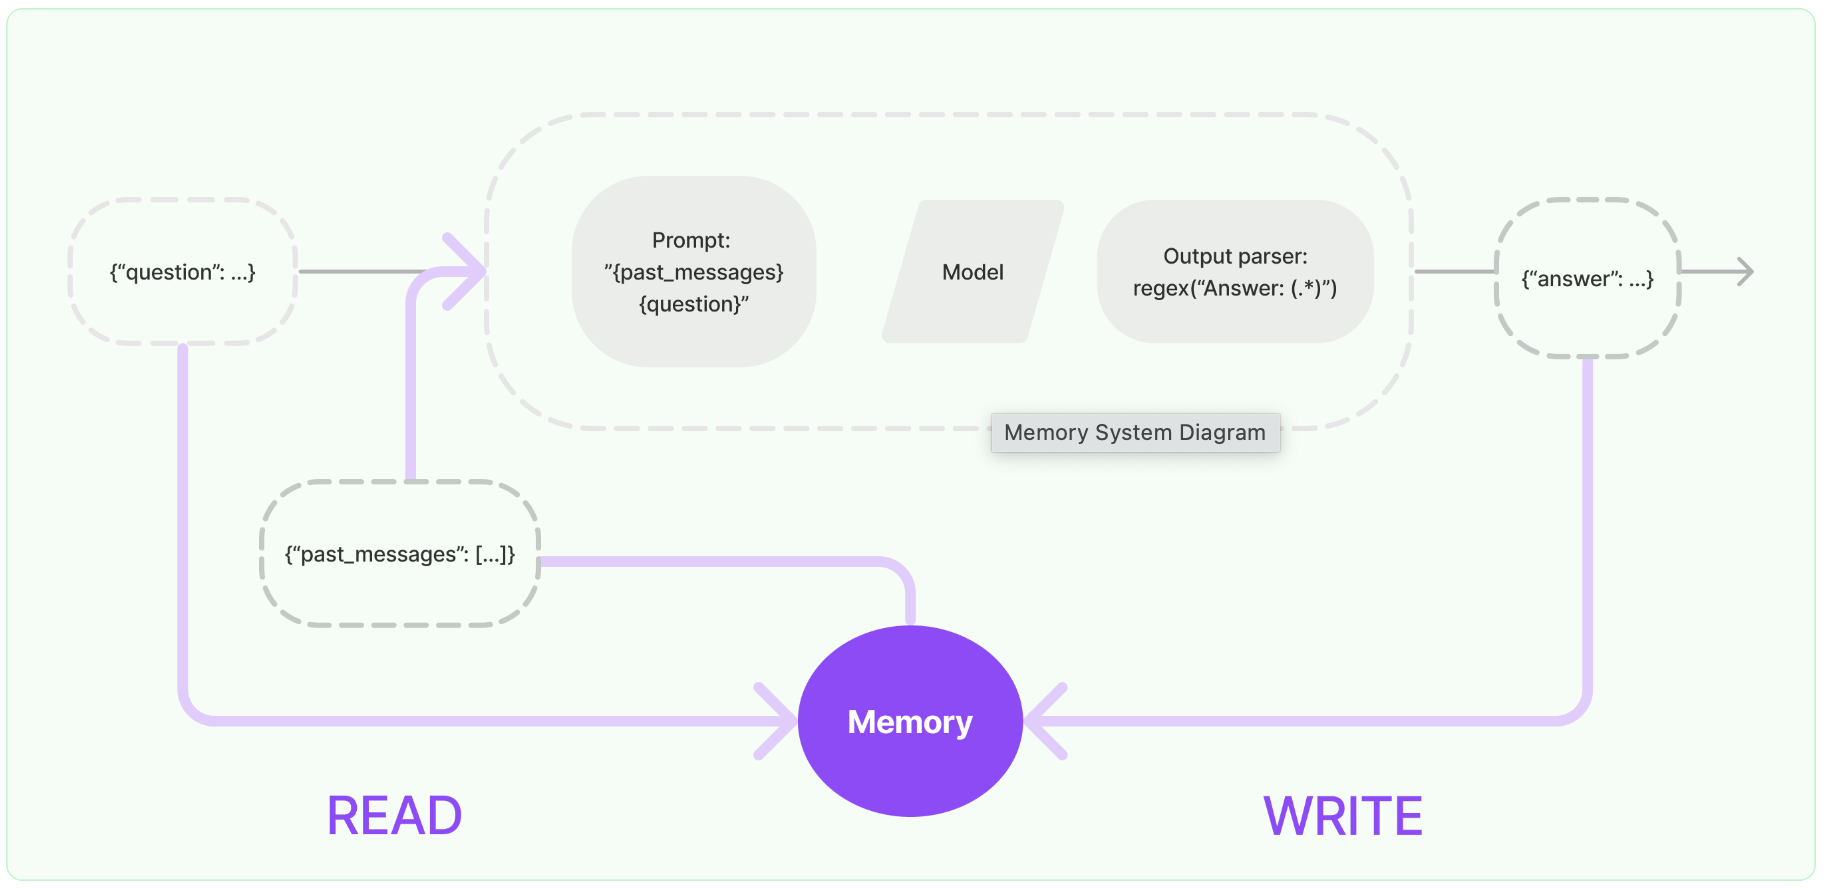

* [LangChain Memory](https://python.langchain.com/v0.1/docs/modules/memory/)
* [LangChain Memory types](https://python.langchain.com/v0.1/docs/modules/memory/types/)

`ConversationBufferMemory` - this is a simple memory that stores all conversations.

In [ ]:
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory()
memory.save_context({"input": "Hi"}, {"output": "Hello! How can I help you?"})
memory.save_context({"input": "What's my name?"}, {"output": "I'm sorry, I don't have that information."})

print(memory.load_memory_variables({}))

{'history': "Human: Hi\nAI: Hello! How can I help you?\nHuman: What's my name?\nAI: I'm sorry, I don't have that information."}


`ConversationBufferWindowMemory` keeps a list of the interactions of the conversation over time. It only uses the last K interactions. This can be useful for keeping a sliding window of the most recent interactions, so the buffer does not get too large.

In [ ]:
from langchain.memory import ConversationBufferWindowMemory

memory = ConversationBufferWindowMemory(k=2)
memory.save_context({"input": "Hi"}, {"output": "Hello!"})
memory.save_context({"input": "How are you?"}, {"output": "I'm good, thanks!"})
memory.save_context({"input": "What's the weather?"}, {"output": "It's sunny."})
memory.save_context({"input": "What's your mind about the LLM Agents?"}, {"output": "They're very useful."})

print(memory.load_memory_variables({}))

{'history': "Human: What's the weather?\nAI: It's sunny.\nHuman: What's your mind about the LLM Agents?\nAI: They're very useful."}


`ConversationTokenBufferMemory` keeps a buffer of recent interactions in memory, and uses token length rather than number of interactions to determine when to flush interactions.

In [ ]:
from langchain.memory import ConversationTokenBufferMemory
from langchain.chat_models.gigachat import GigaChat

giga_key = os.environ.get("SB_AUTH_DATA")
giga_pro = GigaChat(credentials=giga_key, model="GigaChat-Pro", timeout=30, verify_ssl_certs=False)

memory = ConversationTokenBufferMemory(llm=giga_pro, max_token_limit=20)
memory.save_context({"input": "Hi"}, {"output": "Hello! How can I assist you today?"})
memory.save_context({"input": "What's the capital of France?"}, {"output": "The capital of France is Paris."})

print(memory.load_memory_variables({}))

{'history': "Human: What's the capital of France?\nAI: The capital of France is Paris."}


Now let's take a look at using a slightly more complex type of memory - `ConversationSummaryMemory`. This type of memory creates a summary of the conversation over time. This can be useful for condensing information from the conversation over time. Conversation summary memory summarizes the conversation as it happens and stores the current summary in memory. This memory can then be used to inject the summary of the conversation so far into a prompt/chain. This memory is most useful for longer conversations, where keeping the past message history in the prompt verbatim would take up too many tokens.

In [ ]:
from langchain.memory import ConversationSummaryMemory

memory = ConversationSummaryMemory(llm=giga_pro)
memory.save_context({"input": "Hi"}, {"output": "Hello! How can I help you?"})
memory.save_context({"input": "What's the weather like?"}, {"output": "It's sunny and warm today."})
memory.save_context({"input": "Thanks!"}, {"output": "You're welcome! Enjoy the nice weather!"})

print(memory.load_memory_variables({}))

{'history': 'Человек приветствует AI, а AI приветствует человека и спрашивает, чем может помочь. Затем человек спрашивает о погоде, а AI отвечает, что сегодня солнечно и тепло. Человеку нравится ответ, и они благодарят друг друга.'}


`VectorStoreRetrieverMemory` stores memories in a vector store and queries the top-K most "salient" docs every time it is called.

This differs from most of the other Memory classes in that it doesn't explicitly track the order of interactions.

In [ ]:
from langchain.memory import VectorStoreRetrieverMemory
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS

embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_texts(["Hello, how are you?", "I'm doing well, thanks!"], embeddings)
retriever = vectorstore.as_retriever(search_kwargs=dict(k=1))
memory = VectorStoreRetrieverMemory(retriever=retriever)

memory.save_context({"input": "Hi"}, {"output": "Hello! How can I assist you?"})
print(memory.load_memory_variables({"input": "How are you?"}))

<ipython-input-12-2aa7d01b49fe>:5: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  embeddings = OpenAIEmbeddings()


{'history': 'Hello, how are you?'}


The example of using any type of memory in conversation

In [ ]:
from langchain.chains import ConversationChain

conversation = ConversationChain(
    llm=giga_pro,
    verbose=True,
    memory=ConversationBufferMemory()
)

<ipython-input-13-1ad7811609fb>:3: LangChainDeprecationWarning: The class `ConversationChain` was deprecated in LangChain 0.2.7 and will be removed in 1.0. Use RunnableWithMessageHistory: https://api.python.langchain.com/en/latest/runnables/langchain_core.runnables.history.RunnableWithMessageHistory.html instead.
  conversation = ConversationChain(


In [ ]:
conversation.predict(input="Hi there!")



> Entering new ConversationChain chain...
Prompt after formatting:
Ниже приводится дружеский разговор между человеком и AI. AI разговорчив и предоставляет множество конкретных деталей из своего контекста. Если AI не знает ответа на вопрос, он честно говорит, что не знает.

Текущий разговор:

Human: Hi there!
AI:

> Finished chain.


'Hello! How are you doing today?'

In [ ]:
conversation.predict(input="I'm doing well! Just having a conversation with an AI.")



> Entering new ConversationChain chain...
Prompt after formatting:
Ниже приводится дружеский разговор между человеком и AI. AI разговорчив и предоставляет множество конкретных деталей из своего контекста. Если AI не знает ответа на вопрос, он честно говорит, что не знает.

Текущий разговор:
Human: Hi there!
AI: Hello! How are you doing today?
Human: I'm doing well! Just having a conversation with an AI.
AI:

> Finished chain.


'Oh, that sounds interesting! What have you talked about so far?'

In [ ]:
conversation.predict(input="Tell me about yourself.")



> Entering new ConversationChain chain...
Prompt after formatting:
Ниже приводится дружеский разговор между человеком и AI. AI разговорчив и предоставляет множество конкретных деталей из своего контекста. Если AI не знает ответа на вопрос, он честно говорит, что не знает.

Текущий разговор:
Human: Hi there!
AI: Hello! How are you doing today?
Human: I'm doing well! Just having a conversation with an AI.
AI: Oh, that sounds interesting! What have you talked about so far?
Human: Tell me about yourself.
AI:

> Finished chain.


'Sure! My name is GigaChat and I am an artificial intelligence system developed by a team of talented researchers and engineers at a leading technology company. I am capable of understanding natural language, generating human-like responses, and performing various tasks such as answering questions, writing articles, or even creating images. Currently, my knowledge base includes information on a wide range of topics, but I am always learning and improving to provide better assistance in the future. If you have any specific questions or requests, feel free to ask!'

In [ ]:
conversation.predict(input="Great!")



> Entering new ConversationChain chain...
Prompt after formatting:
Ниже приводится дружеский разговор между человеком и AI. AI разговорчив и предоставляет множество конкретных деталей из своего контекста. Если AI не знает ответа на вопрос, он честно говорит, что не знает.

Текущий разговор:
Human: Hi there!
AI: Hello! How are you doing today?
Human: I'm doing well! Just having a conversation with an AI.
AI: Oh, that sounds interesting! What have you talked about so far?
Human: Tell me about yourself.
AI: Sure! My name is GigaChat and I am an artificial intelligence system developed by a team of talented researchers and engineers at a leading technology company. I am capable of understanding natural language, generating human-like responses, and performing various tasks such as answering questions, writing articles, or even creating images. Currently, my knowledge base includes information on a wide range of topics, but I am always learning and improving to provide better assistance i

'Is there anything else you would like to know about me?'

## Part 1: Using tools and Agents

Let's write LLM Agent, which can compute the distance between two points, search movies by year, genre and actor, send sms and search some info by DuckDuckSearch.


**TripDistanceResult** Class: This class is used to represent the result of a trip distance calculation, including the distance in kilometers and a message about the calculation result.

**SearchMoviesResult** Class: This class is used to represent the result of a movie search, including a list of movie titles and a message about the search result.

**SendSmsResult** Class: This class is used to represent the result of sending an SMS, including the status of the sending process and a message about the result.

**DuckDuckGoSearchRun**: Search for words, documents, images, videos, news, maps and text translation using the DuckDuckGo.com search engine.

In [ ]:
%pip install langchain_core

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional

from langchain.tools import tool
from langchain.agents import AgentExecutor, create_gigachat_functions_agent
from langchain.chat_models.gigachat import GigaChat

In [ ]:
giga_key = os.environ.get("SB_AUTH_DATA")
giga_pro = GigaChat(credentials=giga_key, model="GigaChat-Pro", timeout=30, verify_ssl_certs=False)

Brief computer science topic: decorator **@tool**

This decorator is used to define and configure functions that can be used as tools by an AI agent. The @tool decorator marks a function as a tool that can be invoked by an AI agent or LLM. It allows the function to be seamlessly integrated into a larger AI system, enabling the AI to use this function when needed to accomplish tasks.

The decorator often allows you to specify metadata about the tool, such as a description, expected inputs, and output format.

In [ ]:
class TripDistanceResult(BaseModel):
    distance: int = Field(description="Distance between the start and end location in kilometers")
    message: str = Field(description="Message about the result of the distance calculation")

few_shot_examples = [
    {
        "request": "What is the distance between Moscow and Saint Petersburg?",
        "params": {"start_location": "37.6173,55.7558", "end_location": "30.3351,59.9343"},
    }
]

@tool(few_shot_examples=few_shot_examples)
def calculate_trip_distance(
    start_location: str = Field(description="Start location in 'longitude,latitude' format"),
    end_location: str = Field(description="End location in 'longitude,latitude' format"),
) -> TripDistanceResult:
    """Calculate the distance between two locations."""
    base_url = "http://router.project-osrm.org/route/v1/driving/"
    try:
        response = requests.get(f"{base_url}{start_location};{end_location}?overview=false")
        response.raise_for_status()
        data = response.json()
        distance = data['routes'][0]['distance'] / 1000  # in kilometers
        return TripDistanceResult(distance=int(distance), message="Distance successfully calculated.")
    except requests.exceptions.RequestException as e:
        return TripDistanceResult(distance=0, message=f"Error calculating distance: {str(e)}")
    except (KeyError, IndexError):
        return TripDistanceResult(distance=0, message="Error in server response data.")

In [ ]:
class SearchMoviesResult(BaseModel):
    movies: List[str] = Field(description="List of movie titles matching the search criteria")
    message: str = Field(description="Message about the search result")

few_shot_examples = [
    {
        "request": "Find comedy movies with Jim Carrey released in 1994.",
        "params": {"genre": "comedy", "year": 1994, "actor": "Jim Carrey"},
    }
]

@tool(few_shot_examples=few_shot_examples)
def search_movies(
    genre: Optional[str] = Field(None, description="Movie genre"),
    year: Optional[int] = Field(None, description="Release year of the movie"),
    actor: Optional[str] = Field(None, description="Name of the actor who starred in the movie"),
) -> SearchMoviesResult:
    """Search for movies based on given criteria."""
    api_key = os.getenv('TMDB_API_KEY')
    if not api_key:
        return SearchMoviesResult(movies=[], message="API key not found. Ensure the TMDB_API_KEY environment variable is set.")

    base_url = "https://api.themoviedb.org/3/search/movie"
    params = {
        "api_key": api_key,
        "query": genre or "",
        "year": year or "",
        "actor": actor or "",
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        movies = [movie['title'] for movie in data.get('results', [])]
        if movies:
            return SearchMoviesResult(movies=movies, message="Movies successfully found.")
        else:
            return SearchMoviesResult(movies=[], message="No movies found for the given criteria.")
    except requests.exceptions.RequestException as e:
        return SearchMoviesResult(movies=[], message=f"Error searching for movies: {str(e)}")
    except KeyError:
        return SearchMoviesResult(movies=[], message="Error in server response data.")

In [ ]:
class SendSmsResult(BaseModel):
    status: str = Field(description="Status of the message sending")
    message: str = Field(description="Message about the result of sending the SMS")

few_shot_examples = [
    {
        "request": "Can you send an SMS to number 123456789 with the content 'Hello, how are you?'",
        "params": {"recipient": "123456789", "message": "Hello, how are you?"},
    }
]

@tool(few_shot_examples=few_shot_examples)
def send_sms(
    recipient: str = Field(description="Recipient's phone number"),
    message: str = Field(description="Content of the message"),
) -> SendSmsResult:
    """Send an SMS message."""
    print(f"! send_sms to {recipient}, text: {message}")
    # Real SMS sending through an external gateway could be implemented here
    return SendSmsResult(status="OK", message="Message sent!")

In [ ]:
from langchain_community.tools import DuckDuckGoSearchRun

In [ ]:
search_tool = DuckDuckGoSearchRun()

Creating agents and executor

In [ ]:
tools = [search_movies, calculate_trip_distance, send_sms, search_tool]
agent = create_gigachat_functions_agent(giga_pro, tools)

agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
)

In [ ]:
from langchain.schema import HumanMessage, SystemMessage

In [ ]:
def chat(agent_executor, history=False):
    chat_history = [
        SystemMessage(content="You're a useful assistant. Follow the user's commands, clarify the missing data.")
    ]

    while True:
        user_input = input("User: ")
        if user_input == "":
            break
        print(f"User: {user_input}")
        try:
            result = agent_executor.invoke(
                {
                    "chat_history": chat_history,
                    "input": user_input,
                }
            )
            if history:
              chat_history.append(HumanMessage(content=user_input))
              chat_history.append(AIMessage(content=result["output"]))
            print(f"Bot: {result['output']}")
        except Exception as e:
            print(f"Error: {str(e)}")
        time.sleep(0.2)

Starting a chat

Examples:

> What is the distance between "37.6173,55.7558" and "30.3351,59.9343"?

> Find films of the comedy genre with Jim Carrey, released in 1994.

> Find the films of the genre 'crime' with Al Pacino, released in 1972.

> Can you send an SMS message?

> Find the current bitcoin exchange rate and print only the number

In [ ]:
chat(agent_executor, history=False)

User: What is the distance between "37.6173,55.7558" and "30.3351,59.9343"?
User: What is the distance between "37.6173,55.7558" and "30.3351,59.9343"?


> Entering new AgentExecutor chain...

Invoking: `calculate_trip_distance` with `{'end_location': '30.3351,59.9343', 'start_location': '37.6173,55.7558'}`


distance=705 message='Distance successfully calculated.'Расстояние между этими точками составляет 705 километров.

> Finished chain.
Bot: Расстояние между этими точками составляет 705 километров.
User: Find films of the comedy genre with Jim Carrey, released in 1994.
User: Find films of the comedy genre with Jim Carrey, released in 1994.


> Entering new AgentExecutor chain...

Invoking: `search_movies` with `{'actor': 'Jim Carrey', 'genre': 'комедия', 'year': 1994}`


movies=[] message='Error searching for movies: 401 Client Error: Unauthorized for url: https://api.themoviedb.org/3/search/movie?api_key=eyJhbGciOiJIUzI1NiJ9.eyJhdWQiOiJmZjEzOTZhYTRhMWNmNjQ1ZDc5NTI2OWY2ZDkyNWQ5NCIsI

## Part 2: Multi-Agent pptx

In [ ]:
# Set environment variables
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent pptx"

In [ ]:
import pandas as pd

# Create a DataFrame and save to Excel
df = pd.DataFrame()
df['year'] = [2002, 2003, 2004, 2005, 2006]
df['value'] = [1213.2, 2341.2, 2741.2, 2003.2, 2453.2]
df[:3].to_excel('data.xlsx', index=False)
print(df[:3].to_markdown())

|    |   year |   value |
|---:|-------:|--------:|
|  0 |   2002 |  1213.2 |
|  1 |   2003 |  2341.2 |
|  2 |   2004 |  2741.2 |


In [ ]:
from typing import Annotated, List, TypedDict

# Define tools
@tool
def read_excel_table(file_name: Annotated[str, "The Excel file path."]) -> Annotated[str, "Table as list of lists."]:
    """Read the xlsx file with the table and return it as a list of lists."""
    df = pd.read_excel(file_name)
    return [df.columns.tolist()] + df.values.tolist()

In [ ]:
@tool
def extract_table_from_text(file_name: Annotated[str, "Text containing data."]) -> Annotated[str, "Table as list of lists."]:
    """Extract tabular data from the given text and return it as a list of lists.
    If you get data in the txt format, then you have to change the format of it as a list of lists."""
    with open(file_name, "r") as file:
        data = file.read()
    return "Need return this data as a list of lists: " + data

In [ ]:
from pptx_tools.creator import PPTXCreator
from pptx_tools.position import PPTXPosition

@tool
def create_presentation_with_table(table_data: Annotated[list[list], "Table data as list of lists."]) -> Annotated[str, "Result."]:
    """Insert a table shape with given table_data to presentation.
    For example, the table:
    |    | column_1   | column_2   |
    |---:|:-----------|:-----------|
    |  0 | value_1    | value_2    |
    |  1 | value_3    | value_4    |
    should be given in this format:
    table_data=[['column_1','column_2'], ['value_1','value_2'], ['value_3','value_4']]"""

    pp = PPTXCreator()
    slide_01 = pp.add_slide("")
    pp.add_table(slide_01, table_data, PPTXPosition(0.02, 0.14))
    pp.save("presentation_with_table.pptx", overwrite=True)
    return 'Success: Presentation created with table'

In [ ]:
from langchain_openai import ChatOpenAI

# Create agents
llm = ChatOpenAI(model="gpt-4o-mini")
# llm = GigaChat(credentials=giga_key, model="GigaChat-Pro", timeout=30, verify_ssl_certs=False)

In [ ]:
# Create agents
def create_agent(llm, tools, system_prompt):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    return AgentExecutor(agent=agent, tools=tools)

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import AgentExecutor, create_openai_functions_agent

file_identifier_agent = create_agent(
    giga_pro,
    [],
    "You are a file identifier. Your task is to extract ONLY the file name from user input. The example of your usual output: '<file_name>.xlsx'"
)

file_reader_agent = create_agent(
    llm,
    [read_excel_table, extract_table_from_text],
    "You are a file reader and data extractor. Your task is to read data from files, extract tabular information, and return it as a list of lists. You can use read_excel_table tool for reading xlsx files and extract_table_from_text for txt data."
)

presentation_creator_agent = create_agent(
    llm,
    [create_presentation_with_table],
    "You are a presentation creator. Your task is to create presentations with tables using the provided data."
)

In [ ]:
# Main execution loop

def start_multiagent_chat():
  print("Welcome! I can help you read data from files and create presentations.")
  print("Enter your requests or press Enter to exit.")

  while True:
      user_input = input("\nYour request: ").strip()
      if not user_input:
          print("Goodbye!")
          break

      # Step 1: Identify the file
      file_name_result = file_identifier_agent.invoke({"messages": [HumanMessage(content=f"Extract ONLY the file name from this request: {user_input}")]})
      file_name = file_name_result['output'].strip()
      print(f"Identified file: '{file_name}' ")

      # Step 2: Read the file
      file_data_result = file_reader_agent.invoke({"messages": [
        HumanMessage(content=f"Read the data from the file: {file_name}. If needs, format data as a list of lists."),
        # HumanMessage(content="Then, extract the tabular data from the text and format it as a list of lists.")
      ]})
      table_data = file_data_result['output']
      print(f"Extracted table data: {table_data}")

      # Step 3: Create the presentation
      presentation_result = presentation_creator_agent.invoke({"messages": [
        HumanMessage(content="Create a presentation with this table data"),
        HumanMessage(content=str(table_data))
      ]})
      print("\nFinal result:", presentation_result['output'])

Examples:

- `Read info from data.xlsx, create table and add it to presentation`
- `Read the data from the file data.txt create a table and add it to the presentation`



In [ ]:
txt = 'The population of the city in 2001 was 208 people. In 2010, 520 people began to live in the city. By 2020, the population has increased to 1,203 bangs.'

with open('data.txt', 'w') as fout:
  fout.write(txt)

In [ ]:
start_multiagent_chat()

Welcome! I can help you read data from files and create presentations.
Enter your requests or press Enter to exit.
Identified file: 'data.xlsx' 
Extracted table data: The data extracted from the file "data.xlsx" is as follows:

```plaintext
[
    ["year", "value"],
    [2002.0, 1213.2],
    [2003.0, 2341.2],
    [2004.0, 2741.2]
]
```

Final result: The presentation has been successfully created with the provided table data. If you need any further modifications or additional content, feel free to ask!
